In [1]:
from IPython.display import clear_output

import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt

# Применение нейронных сетей в НЕ стационарных временных рядах (Продолжение)
----
Теперь повторим анализ, сделанный в предыдущем ноутбуке, но для действиетльно нестационарного временного ряда - курса акций.

И посмотрим, как поведет себя ARIMA и нейронная сеть.

## 1. Когда достаточно Mashine Learning

### 1.2 Загрузка данных

Давайте скачаем и проанализируем набор данных [AirPassengers](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/09/AirPassengers.csv), который мы будем использовать. Этот пример уже можно считать классическим.

In [2]:
!pip install yfinance
#import yfinance as yf ## Библиотека для получения данных об акциях
# fetch data by interval (including intraday if period < 60 days)
# valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
# (optional, default is '1d')
import yfinance as yf
clear_output()

In [3]:
## Загрузка и сохранение первичных данных
tickers = ['SBER.ME']
df = yf.download(tickers,start='2010-01-01', end = '2021-12-31', interval = '1wk')
df.index = pd.to_datetime(df.index)

del df['Open'], df['High'], df['Low'], df['Adj Close'], df['Volume']
df = df.dropna()
print(df.shape)
df.head()

[*********************100%***********************]  1 of 1 completed
(489, 1)


,Close
Date,
2011-11-21,78.269997
2011-11-28,89.500000
2011-12-05,82.400002
2011-12-12,80.629997
2011-12-19,80.000000


### 1.3 Методы проверки стационарности

Следующий шаг - определить, является ли данный ряд стационарным или нет.

Вот некоторые общие методы, которые мы можем использовать для выполнения этой проверки.

#### Визуальный тест

Рассмотрим график так, как мы это делали в примере выше: мы можем определить ряд, в котором среднее значение, дисперсия и ковариация менялись со временем. Точно так же мы можем построить данные и определить, меняются ли свойства ряда со временем или нет.

<AxesSubplot:xlabel='Date'>

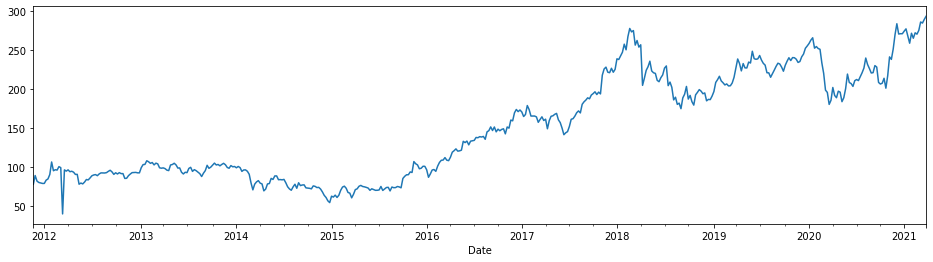

In [4]:
plt.figure(figsize=(16, 4))
df['Close'].plot()

#### ADF (Augmented Dickey Fuller) Test
Тест Дики Фуллера - один из самых популярных статистических тестов.

Его можно использовать для определения наличия единичного корня в ряду и, следовательно, помочь нам понять, является ли ряд стационарным или нет.

Нулевая и альтернативная гипотезы этого теста:
- Нулевая гипотеза: ряд имеет единичный корень (значение a = 1)
- Альтернативная гипотеза: у ряда нет единичного корня.

Если нам не удастся отвергнуть нулевую гипотезу, мы можем сказать, что ряд нестационарен.
Это означает, что ряд может быть линейным или разностным стационарным (мы узнаем больше о разностном стационарном в следующем разделе).

In [5]:
#define function for ADF test
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(df['Close'])

Results of Dickey-Fuller Test:
Test Statistic                  -0.546050
p-value                          0.882713
#Lags Used                       0.000000
Number of Observations Used    488.000000
Critical Value (1%)             -3.443821
Critical Value (5%)             -2.867481
Critical Value (10%)            -2.569934
dtype: float64


Тест на стационарность: Когда Test Statistic превышает Critical Value, мы не можем отклонить нулевую гипотезу (что означает, что ряд не является стационарным).

В нашем примере выше Test Statistic > Critical Valueя, что означает, что ряд не является стационарным.
Это подтверждает наше первоначальное наблюдение, которое мы первоначально видели в визуальном тесте.

#### 2. KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test

KPSS - еще один тест для проверки стационарности временного ряда (немного менее популярный, чем тест Дики Фуллера).

Нулевая и альтернативная гипотезы для теста KPSS противоположны гипотезе теста ADF, что часто вызывает путаницу.

Авторы теста KPSS определили нулевую гипотезу, поскольку процесс является стационарным по тренду, к альтернативной гипотезе ряда единичного корня.

Давайте посмотрим на результаты теста KPSS:
- Нулевая гипотеза: процесс является стационарным.
- Альтернативная гипотеза: ряд имеет единичный корень (ряд не является стационарным).

In [6]:
import warnings
warnings.filterwarnings("ignore")

#define function for kpss test
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print(kpss_output)

kpss_test(df['Close'])

Results of KPSS Test:
Test Statistic            2.334431
p-value                   0.010000
Lags Used                18.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Тест на стационарность: если статистика теста больше критического значения, мы отклоняем нулевую гипотезу (ряд не является стационарным), если не удалось отклонить нулевую гипотезу (ряд стационарный).

Для данных авиапассажиров значение тестовой статистики превышает критическое значение на всех доверительных интервалах, и, следовательно, мы можем сказать, что ряд не является стационарным.

Может случиться так, что оба теста покажут противоречивые результаты.
Это потому, что существует более одного типа стационарности:
- тест ADF имеет альтернативную гипотезу о линейной или диффиренцируемой стационарности
- а тест KPSS определяет стационарность тренда в серии.

### 1.5 Создание стационарного временного ряда

#### Дифференцирование
В этом методе мы вычисляем разность последовательных членов в серии.

Дифференцирование обычно выполняется, чтобы избавиться от переменного среднего.

Математически разность можно записать как:
y(t)‘= y(t) — y(t-1),
где y(t) - значение в момент времени t

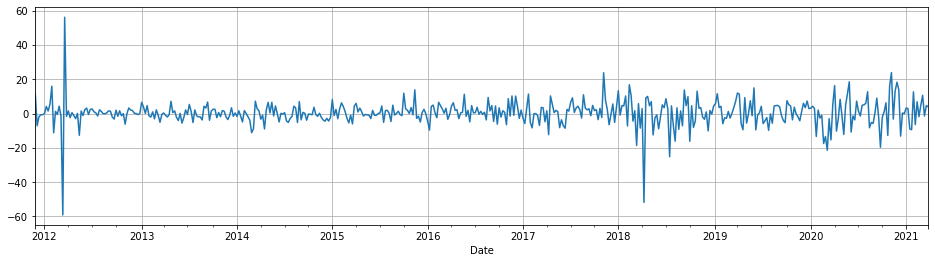

In [7]:
df['Close_diff'] = df['Close'] - df['Close'].shift(1)
plt.figure(figsize=(16, 4))
df['Close_diff'].dropna().plot()
plt.grid()

#### Выделение сезонности (Seasonal Differencing)
При выделении сезонности вместо вычисления разницы между последовательными значениями мы вычисляем разницу между наблюдением и предыдущим наблюдением того же сезона.

Например, наблюдение, сделанное в понедельник, будет вычтено из наблюдения, сделанного в предыдущий понедельник.

Математически это можно записать так: y(t)‘= log(y(t)) — log(y(t-1)), где y(t) - значение в момент времени t

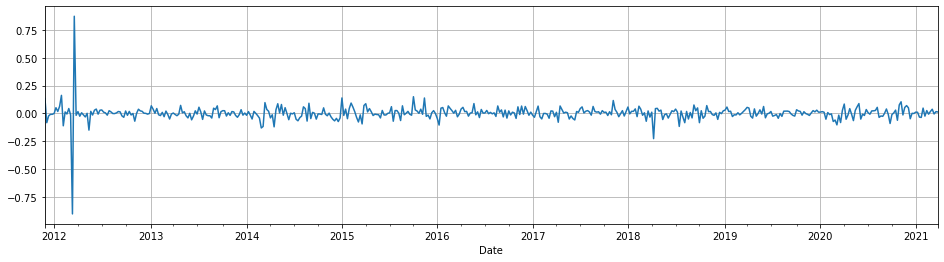

In [8]:
df['Close_log'] = np.log(df['Close'])
df['Close_log_diff'] = df['Close_log'] - df['Close_log'].shift(1)
df = df.dropna()

plt.figure(figsize=(16, 4))
df['Close_log_diff'].plot()
plt.grid()

In [9]:
df.mask(df.eq('None')).dropna()

,Close,Close_diff,Close_log,Close_log_diff
Date,,,,
2011-11-28,89.500000,11.230003,4.494239,0.134074
2011-12-05,82.400002,-7.099998,4.411585,-0.082653
2011-12-12,80.629997,-1.770004,4.389871,-0.021715
2011-12-19,80.000000,-0.629997,4.382027,-0.007844
2011-12-26,79.400002,-0.599998,4.374498,-0.007528
...,...,...,...,...
2021-03-01,274.959991,4.850006,5.616626,0.017796
2021-03-08,285.649994,10.690002,5.654767,0.038142
2021-03-15,284.299988,-1.350006,5.650030,-0.004737


Как видите, этот график является значительным улучшением по сравнению с предыдущими графиками.

### Декомпозиция
---
- Base Level (базовый сигнал)
- Trend (тренд)
- Seasonality (сезонность)
- Error (ошибка)

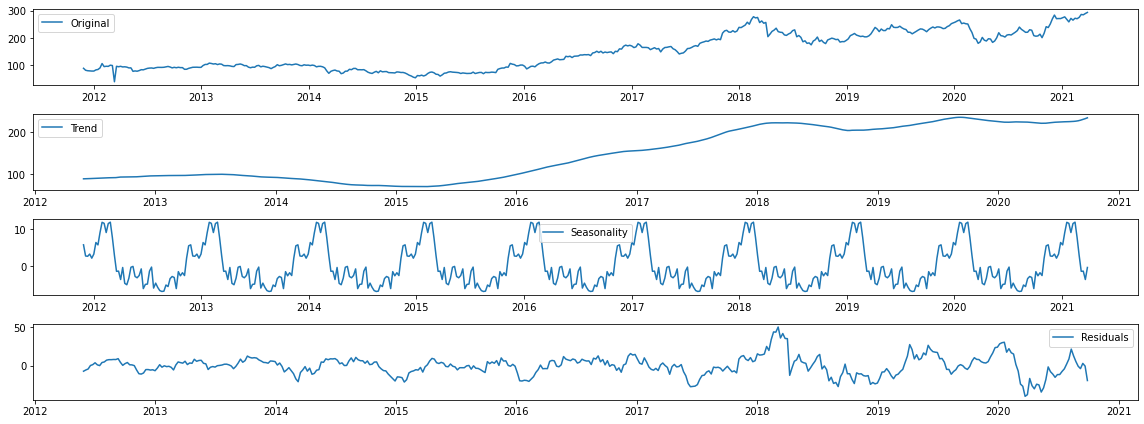

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Close'])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16, 6))
plt.subplot(411)
plt.plot(df['Close'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Однако не обязательно, чтобы все временные ряды имели тренд и/или сезонность.

В зависимости от характера тренда и сезонности временной ряд может быть смоделирован как аддитивный или мультипликативный. При этом каждое наблюдение в ряду может быть выражено либо как сумма, либо как произведение компонентов.

### Resampling
Для анализа цикличных зависимостей, используется функция df.resample (), которая позволяет нам перегруппировать наши временные ряды до желаемых частот.

Например, по кварталам, или по годам.

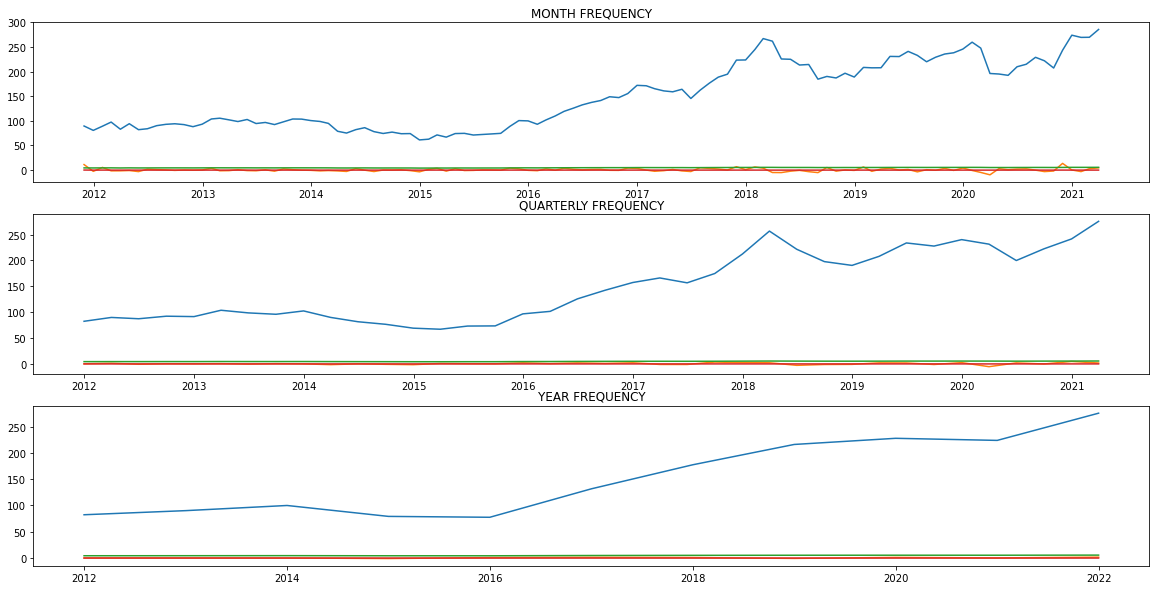

In [11]:
fig, (ax1,ax2,ax3) = plt.subplots(3,figsize=(20,10))

ax1.plot(df.resample('M').mean())
ax1.set_title('MONTH FREQUENCY');

ax2.plot(df.resample('Q').mean())
ax2.set_title('QUARTERLY FREQUENCY');

ax3.plot(df.resample('A').mean())
ax3.set_title('YEAR FREQUENCY');

### Сделаем предикт с помощью ARIMA
ARIMA - это авторегрессионная интегрированная модель скользящего среднего, которая определяется тремя параметрами порядка: (p, d, q).

И тут мы схитрим :)

Используем функцию auto_arima из библиотеки pmdarima для того, чтобы определить наиболее оптимальные параметры для модели ARIMA и плучить наилучшим образом подобранную модель ARIMA. Не факт, что мы смогли бы достигнуть такого результата без auto_arima.

In [12]:
# To install the library
#!pip install pmdarima
clear_output()
  
# Import the library
from pmdarima import auto_arima
  
# Fit auto_arima function to AirPassengers dataset
stepwise_fit = auto_arima(df['Close'], start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise
  
# To print the summary
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=4303.898, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=3457.672, Time=0.49 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=3939.421, Time=0.55 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=4323.250, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=3595.539, Time=0.07 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=3418.665, Time=2.39 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.07 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=4304.423, Time=1.84 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=3416.835, Time=3.18 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=3455.157, Time=0.61 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.05 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.25 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=3

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  488
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 12)   Log Likelihood               -1701.442
Date:                            Mon, 29 Mar 2021   AIC                           3414.885
Time:                                    23:09:49   BIC                           3439.877
Sample:                                         0   HQIC                          3424.712
                                            - 488                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8738      0.030     28.953      0.000       0.815       0.933
ar.L2          0.1691      0.047      3.589      0.000       0.077       0.261
ar.L3         -0.0877      0.037     -2.339      0.019      -0.161      -0.014
ar.S.L12      -0.7063      0.027    -25.740      0.000      -0.760      -0.652
ar.S.L24      -0.3165      0.030    -10.534      0.000      -0.375      -0.258
sigma2        73.2394      2.528     28.976      0.000      68.285      78.193
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               991.76
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               2.06   Skew:                            -0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Date'>

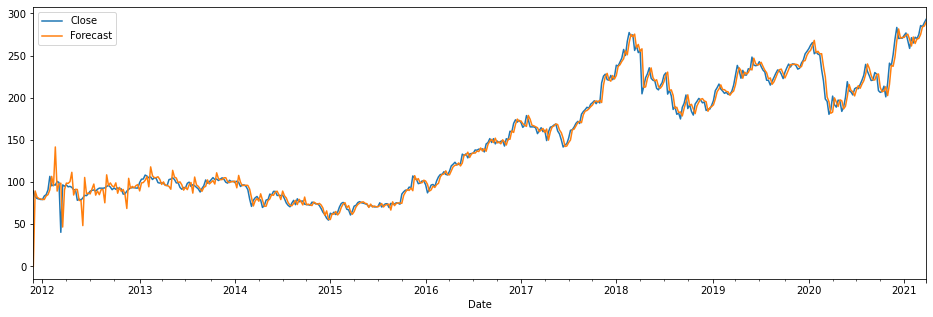

In [13]:
#Forecast using ARIMA Model
# Fit a SARIMAX(3, 0, 0)x(2, 1, 0, 12) on the training set
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Train the model on the full dataset
model = SARIMAX(df['Close'], 
                order = (0, 1, 1), 
                seasonal_order =(2, 1, 1, 12))
result = model.fit()
  
# Forecast for the next 3 years
forecast = result.predict(start = 0, 
                          end = (len(df['Close'])-1) + 0, 
                          typ = 'levels').rename('Forecast')
  
# Plot the forecast values
df['Close'].plot(figsize = (16, 5), legend = True)
forecast.plot(legend = True)

### Вывод:
Таким образом, мы:
1. Ппознакомились с вариантами выполнения анализа временного ряда перед применение методов Mashing Learning
2. Увидели, что для применения обычных методов ML требуется провести достаточно большую предварительную обработку данных, которые, нейронная сети делает "автоматически"
3. Наблюдается автокорреляция с ценой (когда модель "предсказывает" предыдущее значение. То есть на лицо явное переобучение модели, октрую подобрал pmdarima

## 2. А теперь сделаем предикт с помощью Deep Learning (PyTorch LSTM)
----
[Time Series Prediction with LSTM Using PyTorchTime Series Prediction with LSTM Using PyTorch](https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb#scrollTo=NabsV8O5BBd5https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb#scrollTo=NabsV8O5BBd5)

- Dataloading
- Скалирование
- Формирование ансамблей данных 
- LSTM Mode
- Traning
- Testing

In [14]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

### Dataloading

In [15]:
## Загрузка и сохранение первичных данных
tickers = ['SBER.ME']
df = yf.download(tickers,start='2010-01-01', end = '2021-12-31', interval = '1wk')
df.index = pd.to_datetime(df.index)

del df['Open'], df['High'], df['Low'], df['Adj Close'], df['Volume']
df = df.dropna()
print(df.shape)
df.head()

[*********************100%***********************]  1 of 1 completed
(489, 1)


,Close
Date,
2011-11-21,78.269997
2011-11-28,89.500000
2011-12-05,82.400002
2011-12-12,80.629997
2011-12-19,80.000000


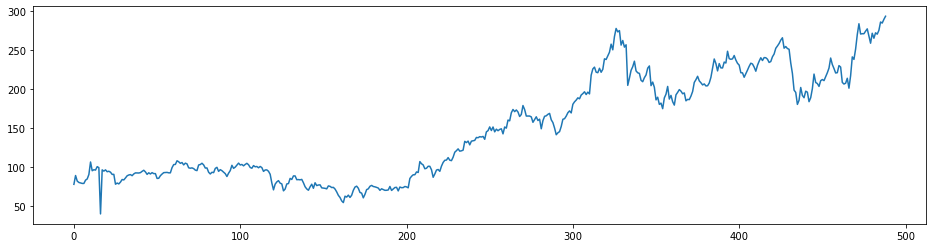

In [16]:
#!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

training_set = df
training_set = training_set.values # перевели dataframe в numpy.array

# plotting
plt.figure(figsize=(16, 4))
plt.plot(training_set)

### Скалирование данных

In [17]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler # проверить все

xScaler = MinMaxScaler()
training_data = xScaler.fit_transform(training_set)

### Формирование ансамблей данных

In [18]:
# функция создания "ансамблей" данных
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [19]:
# установка длины ансамбля. от нее практически всегда зависит точность предикта и быстродействие
seq_length = 8 # сравните 2 и 32
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

trainX.shape, trainY.shape, testX.shape, testY.shape

(torch.Size([384, 8, 1]),
 torch.Size([384, 1]),
 torch.Size([96, 8, 1]),
 torch.Size([96, 1]))

### LSTM Model
Ее преимущество при применении в нестационарных временных рядах заключается в способности выявления взаимосвязей данных внутри временных рядов и "автоматическое" выделение различных типов сезонности, тенденций изменений дисперсий, ковариации и проч характеристик временного ряда..

In [20]:
class LSTM(nn.Module):
    """
    num_classes :
    input_size  :
    hidden_size :
    num_layers  :
    
    """
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers  = num_layers
        self.input_size  = input_size
        self.hidden_size = hidden_size
        self.seq_length  = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True,
                            dropout = 0.4)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        
        return out

### Traning

In [21]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
# Сложность нейронки должна быть адекватна датасету !!!
hidden_size = seq_length # а можно попробовать 400 - в чем разница?
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.48452
Epoch: 100, loss: 0.00118
Epoch: 200, loss: 0.00108
Epoch: 300, loss: 0.00101
Epoch: 400, loss: 0.00095
Epoch: 500, loss: 0.00089
Epoch: 600, loss: 0.00085
Epoch: 700, loss: 0.00081
Epoch: 800, loss: 0.00079
Epoch: 900, loss: 0.00078
Epoch: 1000, loss: 0.00077
Epoch: 1100, loss: 0.00076
Epoch: 1200, loss: 0.00076
Epoch: 1300, loss: 0.00076
Epoch: 1400, loss: 0.00075
Epoch: 1500, loss: 0.00075
Epoch: 1600, loss: 0.00075
Epoch: 1700, loss: 0.00075
Epoch: 1800, loss: 0.00075
Epoch: 1900, loss: 0.00075


### Testing

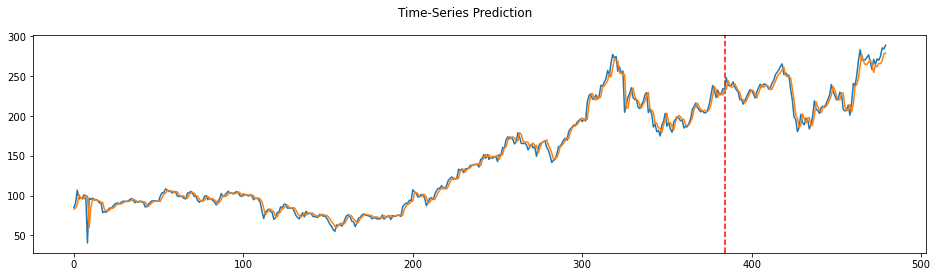

In [22]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = xScaler.inverse_transform(data_predict)
dataY_plot = xScaler.inverse_transform(dataY_plot)

# Ploitting
plt.figure(figsize=(16, 4))
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

### Выводы:
---
1. Использование LSTM слоев при прогнозировании нестационарных временных рядов - отличное решение, тк нейронка способна самостоятельно выденить динамики изменениях составляющих временного ряда. Правда, в более сложных случаях (трейдинге, например, или чтении и расшивровки волн мозга) приходится прибегать к feature ingineering
2. Сложость нейронной сети должна быть адекватна сложности подаваемых в нее данных. С ростом ансамбля и числа нейронов увеличивается заучивание тренировочной выборки и теряется способность к обощению
3. Предварительный анализ цикличности в данных (если она есть) помогает понять оптимальный размер ансамбля (тут видно, что цикл в среднем составляет 8 интервалов)
4. Также результат может зависеть от типа скалирования, который Вы применяете. Нужно знать принципы работы скаллеров и не стесняться экспериментировать с ними. См. статьи: [Data Preprocessing with Scikit-Learn: Standardization and Scaling](https://towardsdatascience.com/data-preprocessing-with-scikit-learn-standardization-and-scaling-cfb695280412) и [Gradient Descent, the Learning Rate, and the importance of Feature Scaling](https://towardsdatascience.com/gradient-descent-the-learning-rate-and-the-importance-of-feature-scaling-6c0b416596e1)
5. При всей выгодности приненении нейронных сетей, необходимо быть осторожным с автокорреляцией (см статью [Avoiding the pitfalls](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424))